# 2110203 COMP ENG MATH II (CEDT) -- Stats Homework III

# A/B Testing from Scratch: Multi-armed Bandits

Frequentist and Bayesian A/B tests require you to divide your traffic into arbitrary groups for a period of time, then perform statistical tests based on the results. By definition, this forces us to divert out traffic to suboptimal variations during the test period, resulting in lower overall conversion rates. On the other hand, multi-barmed bandit appraoch (MAB) dynamically adjusts the percentage of traffic shown to each variation according to how they have performed so far during the test, resulting in smaller loss in conversion rates.

![Traditional A/B Test vs Multi-armed Bandits](https://github.com/cstorm125/abtestoo/blob/master/images/ab_vs_mab.png?raw=true)

Source: [Automizy](https://automizy.com/blog/increase-email-course-open-rates-with-machine-learning/) via [Multi-Arm Bandits: a potential alternative to A/B tests](https://medium.com/brillio-data-science/multi-arm-bandits-a-potential-alternative-to-a-b-tests-a647d9bf2a7e)

In [ ]:
import numpy as np
import pandas as pd

# widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

# plots
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, theme_minimal, facet_wrap

# stats
import scipy as sp
import statsmodels as sm

import warnings
warnings.filterwarnings("ignore")

## Arms, Variations, Ads, or Anything

We treat serving a variation of content, be it product listings, recommended products, search results, online ads, or whatever we want to experiment on as *pulling an arm*. The arm will record an impression and, at an arbitrary amount of delay time, an action such as a click or add-to-cart based on that impression. In our example, we define our arm as a Bernoulli trial with the true probability of conversion ($\frac{actions}{impressions}$) as `true_p`.

In [2]:
class Arm:
    def __init__(self, true_p):
        self.true_p = true_p
        self.reset()

    def reset(self):
        self.impressions = 0
        self.actions = 0

    def get_state(self):
        return self.impressions, self.actions

    def get_rate(self):
        return self.actions / self.impressions if self.impressions > 0 else 0.

    def pull(self):
        self.impressions += 1
        res = 1 if np.random.random() < self.true_p else 0
        self.actions += res
        return res

In [3]:
a = Arm(0.1)
for i in range(100):
    a.pull()

a.get_state()

(100, 16)

## Environment

We simulate an environment is an arbitrary number of arms with a set of predefined true probability `true_p` and average number of rewards `avg_rewards` per time period `t`. This environment mimics most content serving APIs which display each variation at the ratio `ps` as defined by experimenters.

In [4]:
class MusketeerEnv:
    def __init__(self, true_ps, avg_impressions):
        self.true_ps = true_ps
        self.avg_impressions = avg_impressions
        self.nb_arms = len(true_ps)
        self.reset()


    def reset(self):
        self.t = -1
        self.ds = []
        self.arms = [Arm(p) for p in self.true_ps]
        return self.get_state()


    def get_state(self):
        return [self.arms[i].get_state() for i in range(self.nb_arms)]


    def get_rates(self):
        return [self.arms[i].get_rate() for i in range(self.nb_arms)]


    # sample the actual number of impressions from a triangular function
    def get_impressions(self):
        return int(
            np.random.triangular(
                self.avg_impressions * 0.5,
                self.avg_impressions,
                self.avg_impressions * 1.5
            )
        )

    # ramdomly choose arm based on a given probabiliy `ps`
    def step(self, ps):
        self.t += 1
        impressions = self.get_impressions()
        
        for i in np.random.choice(a=self.nb_arms, size=impressions, p=ps):
            self.arms[i].pull()
        
        self.record()
        return self.get_state()


    # for logging
    def record(self):
        d = {"t": self.t, "max_rate": 0.0, "opt_impressions": 0.0}

        for i in range(self.nb_arms):
            d[f"impressions_{i}"], d[f"actions_{i}"] = self.arms[i].get_state()
            d[f"rate_{i}"] = self.arms[i].get_rate()

            if d[f"rate_{i}"] > d["max_rate"]:
                d["max_rate"] = d[f"rate_{i}"]
                d["opt_impressions"] = d[f"impressions_{i}"]


        d["total_impressions"] = sum([self.arms[i].impressions for i in range(self.nb_arms)])
        d["opt_impressions_rate"] = d["opt_impressions"] / d["total_impressions"]
        
        d["total_actions"] = sum([self.arms[i].actions for i in range(self.nb_arms)])
        d["total_rate"] = d["total_actions"] / d["total_impressions"]
        
        d["regret_rate"] = d["max_rate"] - d["total_rate"]
        d["regret"] = d["regret_rate"] * d["total_impressions"]
        self.ds.append(d)


    # for printing
    def show_df(self):
        df = pd.DataFrame(self.ds)
        cols = ["t"] + [f"rate_{i}" for i in range(self.nb_arms)] + \
               [f"impressions_{i}" for i in range(self.nb_arms)] + \
               [f"actions_{i}" for i in range(self.nb_arms)] + \
               ["total_impressions", "total_actions", "total_rate"] + \
               ["opt_impressions", "opt_impressions_rate"] + \
               ["regret_rate", "regret"]
               
        df = df[cols]
        return df

For instance, in a traditional A/B test with a default variation, new variation `A` and new variation `B`. We may divide 60% traffic to the default variation and 20% each to `A` and `B`. After 1,000 time steps, we will get the following results.

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def animate_rates(
    df,
    ps,
    save_dir = "../images/",
    file_name = "arm_rates_animation"
):
    """
    Create an animated bar chart showing rate_i vs time and save both
    a .gif animation and a final static .png frame.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 't', 'rate_0', 'rate_1', ..., 'rate_(n-1)'
    ps : list or np.ndarray
        True rates for each element (same length as number of rate_i columns)
    save_dir : str, default="../images/"
        Directory path to save the outputs
    file_name : str, default="arm_rates_animation"
        Base name (without extension) for output files
    """

    # --- Preparation ---
    os.makedirs(save_dir, exist_ok=True)

    # Extract rate columns
    rate_cols = [col for col in df.columns if col.startswith("rate_")]
    n = len(rate_cols)
    t_values = df["t"].values

    # Determine limits
    max_rate = df[rate_cols].to_numpy().max()
    y_max = max_rate * 1.1

    # Output paths
    gif_path = os.path.join(save_dir, f"{file_name}.gif")
    png_path = os.path.join(save_dir, f"{file_name}_final.png")

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(range(n), df.iloc[0][rate_cols].values, color="skyblue", label="Current Rate")
    
    # Plot reference lines for ps
    for i, val in enumerate(ps):
        ax.hlines(val, i - 0.4, i + 0.4, colors='r', linestyles='dashed', label='True Rate' if i == 0 else "")
    
    ax.set_ylim(0, y_max)
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_xlabel("Element Index")
    ax.set_ylabel("Rate")
    ax.set_title("Rates over Time (t = 0)")
    ax.legend(loc="upper left")

    # Label text objects above bars
    labels = [ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                      f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=8)
              for bar in bars]

    # --- Update function ---
    def update(frame_idx):
        current_rates = df.iloc[frame_idx][rate_cols].values
        for bar, new_height, label in zip(bars, current_rates, labels):
            bar.set_height(new_height)
            label.set_y(new_height)
            label.set_text(f"{new_height:.2f}")
        ax.set_title(f"Rates over Time (t = {t_values[frame_idx]})")
        return list(bars) + labels

    # --- Animation configuration ---
    total_frames = len(df)
    total_duration_sec = min(total_frames / 100, 10.0)
    frame_interval_ms = (total_duration_sec / total_frames) * 100

    ani = FuncAnimation(fig, update, frames=total_frames, blit=False, repeat=False)

    # --- Save GIF ---
    fps = int(1000 / frame_interval_ms)
    writer = PillowWriter(fps=fps)
    ani.save(gif_path, writer=writer)

    # --- Save final frame ---
    update(total_frames - 1)
    plt.savefig(png_path, dpi=200)

    plt.close(fig)
    print(f"✅ Animation saved to: {gif_path}")
    print(f"✅ Final frame saved to: {png_path}")

In [66]:

N = 1000
env = MusketeerEnv(true_ps = [0.1, 0.12, 0.13], avg_impressions=400)

for i in range(N):
    env.step([0.6, 0.2, 0.2])

print(env.get_rates())

df = env.show_df()
display(df.head())
display(df.tail())

[0.10105293511494082, 0.11896350142334282, 0.12847704039413885]


,t,rate_0,rate_1,rate_2,impressions_0,impressions_1,impressions_2,actions_0,actions_1,actions_2,total_impressions,total_actions,total_rate,opt_impressions,opt_impressions_rate,regret_rate,regret
0,0,0.108527,0.113636,0.166667,258,88,90,28,10,15,436,53,0.121560,90,0.206422,0.045107,19.666667
1,1,0.107865,0.166667,0.145695,445,144,151,48,24,22,740,94,0.127027,144,0.194595,0.039640,29.333333
2,2,0.104452,0.148936,0.120603,584,188,199,61,28,24,971,113,0.116375,188,0.193615,0.032561,31.617021
3,3,0.103356,0.141667,0.112500,745,240,240,77,34,27,1225,138,0.112653,240,0.195918,0.029014,35.541667
4,4,0.097487,0.142857,0.121019,995,315,314,97,45,38,1624,180,0.110837,315,0.193966,0.032020,52.000000


,t,rate_0,rate_1,rate_2,impressions_0,impressions_1,impressions_2,actions_0,actions_1,actions_2,total_impressions,total_actions,total_rate,opt_impressions,opt_impressions_rate,regret_rate,regret
995,995,0.101092,0.119007,0.128492,235004,78424,78293,23757,9333,10060,391721,43150,0.110155,78293,0.199869,0.018337,7182.893873
996,996,0.101071,0.118965,0.128478,235211,78485,78356,23773,9337,10067,392052,43177,0.110131,78356,0.199861,0.018347,7192.945939
997,997,0.101065,0.118974,0.128494,235404,78555,78416,23791,9346,10076,392375,43213,0.110132,78416,0.199850,0.018362,7204.905785
998,998,0.101028,0.118952,0.128492,235668,78637,78503,23809,9354,10087,392808,43250,0.110105,78503,0.199851,0.018387,7222.648128
999,999,0.101053,0.118964,0.128477,235817,78688,78551,23830,9361,10092,393056,43283,0.110119,78551,0.199847,0.018358,7215.671589


In [7]:
animate_rates(
    df=df.head(200),
    ps=env.true_ps,
    save_dir="../images/",
    file_name="musketeer_arm_rates_animation"
)

✅ Animation saved to: ../images/musketeer_arm_rates_animation.gif
✅ Final frame saved to: ../images/musketeer_arm_rates_animation_final.png


In order to evaluate an MAB agent, we use 3 main metrics:
1. `opt_impressions_rate`: cumulative percentage of impressions we have given to the optimal arm at that timestep; this shows us how often we have picked the "best" arm
2. `regret_rate`: cumulative conversion rate of the best arm at that timestep minus cumulative conversion rate of all impressions; this shows us the difference in conversion rate we have lost by not picking the "best" arm
3. `regret`: cumulative actions if we had chosen the "best" arm minus actual cumulative conversions; this shows us how much actions we have lost by not picking the "best" arm

## Agent

An MAB agent solves the explore-vs-exploit dilemma. Exploitation means we choose what we know as the best choice at the current timestep, sometimes called being *greedy*; on the other hand, exploration means we try pulling other arms in order to know more about the environment.

Exploiting 100% of the time is a bad idea. For instance; let us assume there are two arms `A` and `B` with true probabilities 0.1 and 0.9 and it happens that when we pull `A` it returns a conversion whereas when we pull `B` it does not. If our policy is to always exploit, we would end up pulling only `A` which has much lower return rate than `B`. This is when you do not have any experiment set up for your content at all.

In contrast, if we always explore, we would end up pulling both arms randomly with expected return rates of $0.9 * 0.5 + 0.1 * 0.5 = 0.5$ instead of much higher if we could find out `B` is the better arm. This is close to what happens in a traditional A/B test during the test period.

Some common policies for distributing impressions to each arm are:
1. **Equal weights**: all arms have the same amount of traffic or a fixed amount.
2. **Randomize**: randomly assign traffic to all arms.
3. **Epsilon-greedy**: Assign a majority of traffic to the "best" arm at that time step, and the rest randomized among all arms; the degree of random traffic can be decayed by a parameter `gamma` as time goes on.
4. **Softmax or Boltzmann exploration**: Assigns traffic equal to the softmax activation of their current return rates; regulated by temperature parameter `tau` (lower `tau` means less exploration) that can also be decayed by `gamma` over time.
$$P(A_i) = \frac{e^{rate_i/\tau}}{\sum{e^{rate_i/\tau}}}$$

5. **Upper Confidence Bound**: by utilizing Hoeffding’s Inequality, we can have a deterministic policy based on number of times the arms are pulled so far and impressions of each arm:

$$A = argmax(rate_i + \sqrt{\frac{2\log{t}}{impressions_i}})$$

6. **Deterministic Thompson Sampling**: based on a posterior distribution (in our case a Beta distribution) for each arm, sample that number of rates. Choose the arm with the highest sampled rate.

7. **Stochastic Thompson Sampling**: Instead of sampling only once, perform a Monte Carlo simulation for an arbitrary number of times, the traffic to each arm is divided by the percentage of times that arm is the best arm in the simulation.

In [107]:
class BanditAgent:
    def __init__(self):
        pass

    # baselines
    def equal_weights(self, state):
        p_actions = np.array([1 / len(state) for i in range(len(state))])
        return p_actions


    # TODO #1: write a function that give the probability of choosing arm randomly
    def randomize(self, state):
        # CODE HERE
        p_actions = np.random.rand(len(state))
        p_actions = p_actions / p_actions.sum()
        return p_actions


    # TODO #2: write a function that give the probability of choosing arm based on epsilon greedy policy
    def eps_greedy(self, state, t, start_eps=0.3, end_eps=0.01, gamma=0.99):
        # CODE HERE
        eps = end_eps + (start_eps - end_eps) * np.exp(-gamma * t)
        
        n_arms = len(state)
        rates = np.array([ (s[1] / s[0] if s[0] > 0 else 0) for s in state ])
        best_arm = np.argmax(rates)
        
        p_actions = np.ones(n_arms) * (eps / n_arms)
        p_actions[best_arm] += (1 - eps)
        return p_actions


    # TODO #3: write a function that give the probability of choosing arm based on softmax greedy policy
    def softmax(self, state, t, start_tau=1e-1, end_tau=1e-4, gamma=0.9):
        tau = end_tau + (start_tau - end_tau) * np.exp(-gamma * t)
        
        rates = np.array([ (s[1] / s[0] if s[0] > 0 else 0) for s in state ])
        max_scaled = np.max(rates / tau)
        exp_rewards = np.exp((rates / tau) - max_scaled)
        
        p_actions = exp_rewards / exp_rewards.sum()
        return p_actions


    # TODO #4: write a function that give the probability of choosing arm based on UCB policy
    def ucb(self, state, t):
        # CODE HERE
        rates = np.array([ (s[1] / s[0] if s[0] > 0 else 0) for s in state ])
        impressions = np.array([ s[0] for s in state ])

        ucbs = rates + np.array([ np.sqrt(2 * np.log(t + 1) / imp) if imp > 0 else float("inf") for imp in impressions ])
        best_arm = np.argmax(ucbs)
        
        p_actions = np.zeros(len(state))
        p_actions[best_arm] = 1.0
        return p_actions

## Simulation Results

We simulate 4 campaigns with true probabilities of 12%, 13%, 15% and, 16% respectively. Our number of overall impressions is 400 on average.

In [108]:
env = MusketeerEnv(true_ps = [0.12, 0.13, 0.15, 0.16], avg_impressions=400)
a = BanditAgent()

for i in range(20):
    p = a.equal_weights(env.get_state())
    env.step(p)
    t = i

results_df = pd.DataFrame(
    (
        a.equal_weights(env.get_state()),
        a.randomize(env.get_state()),
        a.eps_greedy(env.get_state(), t),
        a.softmax(env.get_state(), t),
        a.ucb(env.get_state(), t)
    ),
    index=["equal_weights", "randomize", "eps_greedy", "softmax", "ucb"]
)
results_df

,0,1,2,3
equal_weights,2.500000e-01,2.500000e-01,0.250000,0.250000
randomize,5.476092e-01,2.092475e-01,0.077919,0.165224
eps_greedy,2.500000e-03,2.500000e-03,0.002500,0.992500
softmax,1.482338e-149,1.964503e-137,0.000017,0.999983
ucb,0.000000e+00,0.000000e+00,0.000000,1.000000


In [109]:
N_policy = 5

envs = [MusketeerEnv(true_ps = [0.12, 0.13, 0.15, 0.16], avg_impressions=400) for i in range(N_policy)]
a = BanditAgent()

for t in range(250):
    states = [env.get_state() for env in envs]
    actions = [
        a.equal_weights(states[0]),
        a.randomize(states[1]),
        a.eps_greedy(states[2], t),
        a.softmax(states[3], t),
        a.ucb(states[4], t)
    ]

    for i in range(N_policy):
        envs[i].step(actions[i])

dfs = [env.show_df() for env in envs]
policies = ["equal_weights", "randomize", "eps_greedy", "softmax", "ucb"]

for i in range(N_policy):
    dfs[i]["policy"] = policies[i]

df = pd.concat(dfs)[["policy", "t", "opt_impressions_rate", "regret_rate", "regret", "total_rate"]]

In [110]:
df.head()

,policy,t,opt_impressions_rate,regret_rate,regret,total_rate
0,equal_weights,0,0.242588,0.023151,8.588889,0.121294
1,equal_weights,1,0.236842,0.037324,24.111111,0.113003
2,equal_weights,2,0.242021,0.036172,40.802198,0.125000
3,equal_weights,3,0.240000,0.028000,45.500000,0.133538
4,equal_weights,4,0.242184,0.031492,63.456967,0.134491


In [111]:
df_m = df.melt(id_vars=["policy", "t"])
df_m.tail()

,policy,t,variable,value
4995,ucb,245,total_rate,0.153102
4996,ucb,246,total_rate,0.153184
4997,ucb,247,total_rate,0.153166
4998,ucb,248,total_rate,0.153208
4999,ucb,249,total_rate,0.153273


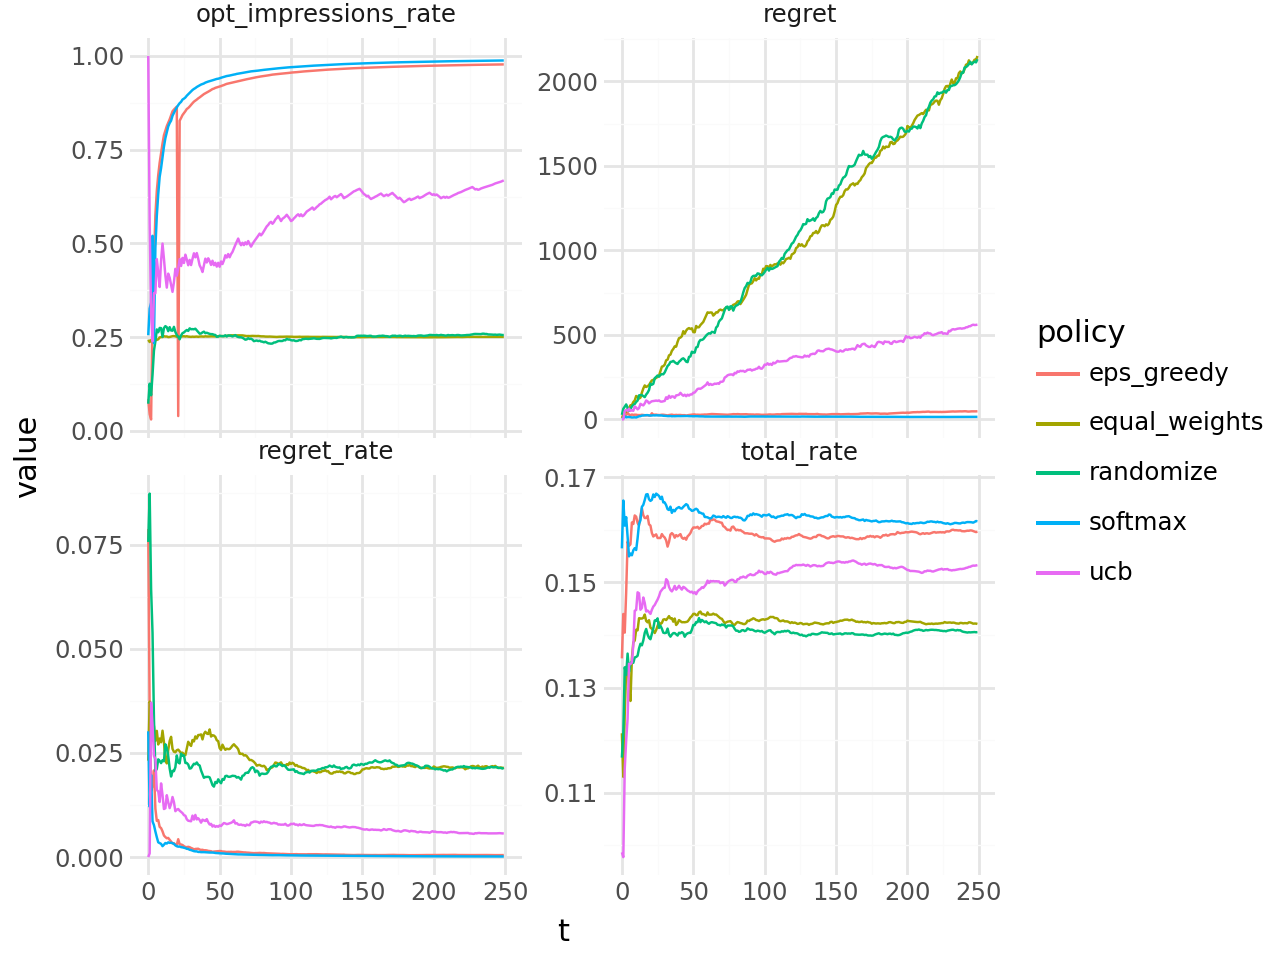

In [114]:
g = (
    ggplot(df_m, aes(x="t", y="value", color="policy", group="policy")) +
    geom_line() +
    theme_minimal() +
    facet_wrap("~variable", scales="free_y")
)

display(g)

TODO #5 Compare the result. Which policy has the best performance ?


**Submit a pdf with screenshots of TODO1-5.**

First, lets print out the final value of `"opt_impressions_rate"`, `"regret_rate"`, `"regret"`, and `"total_rate"`
```python
df[df["t"]==df["t"].max()]
```

To select the best performance algorithm, we should choose the algorithm that has the highest `"total_rate"` and the lowest `"regret"` among all algorithms.

The following is the result of the simulation.
| Algorithm            | opt_impressions_rate | regret_rate | regret      | total_rate |
|----------------------|----------------------|-------------|-------------|------------|
| equal_weights        | 0.250529             | 0.021550    | 2150.471960 | 0.142090   |
| randomize            | 0.255510             | 0.021394    | 2131.409491 | 0.140533   |
| eps_greedy           | 0.977498             | 0.000487    | 48.635314   | 0.159635   |
| softmax              | 0.987997             | 0.000152    | 15.510418   | 0.161609   |
| ucb                  | 0.667973             | 0.005684    | 561.241847  | 0.153273   |

Since, the `softmax` algorithm has the highest `"total_rate"` of `0.161609` and the lowest `"regret"` of `15.510418`, we can conclude that the `softmax` algorithm has the best performance among all algorithms.

In [116]:
df[df["t"]==df["t"].max()]

,policy,t,opt_impressions_rate,regret_rate,regret,total_rate
249,equal_weights,249,0.250529,0.021550,2150.471960,0.142090
249,randomize,249,0.255510,0.021394,2131.409491,0.140533
249,eps_greedy,249,0.977498,0.000487,48.635314,0.159635
249,softmax,249,0.987997,0.000152,15.510418,0.161609
249,ucb,249,0.667973,0.005684,561.241847,0.153273


## References

Here are some useful resources reviewed for this notebook.

- [tl;dr Bayesian A/B test](https://medium.com/hockey-stick/tl-dr-bayesian-a-b-testing-with-python-c495d375db4d)
- [Bayesian A/B Testing: a step-by-step guide](http://www.claudiobellei.com/2017/11/02/bayesian-AB-testing/)
- [Bayesian Coin Flips](https://www.thomasjpfan.com/2015/09/bayesian-coin-flips/)
- [Multi-Arm Bandits: a potential alternative to A/B tests](https://medium.com/brillio-data-science/multi-arm-bandits-a-potential-alternative-to-a-b-tests-a647d9bf2a7e)
- [Multi Armed Bandits and Exploration Strategies](https://sudeepraja.github.io/Bandits/)
- [MAB Google](https://support.google.com/analytics/answer/2846882?hl=en)